# Multispectral Rendering

This notebook demonstrates how to solve the Radiative Transfer using SHDOM and render multispectral images. 

The images rendered are at several wavelengths for which a mie tables were previously calculated.

---

Related tutorials: 
 - Make Mie Table.ipynb - how to create mie tables
 - Single Image Rendering.ipynb - how to create a single monochromatic image
 - Multiview Rendering.ipynb - how to create multiview images

---

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np

import shdom

In [2]:
""" 
Load previously saved mie tables at several wavelengths and define a list of atmospheres with
the corresponding Rayleigh and Mie scattering for each shdom.Medium object.
"""
wavelengths = [0.672, 0.550, 0.445]
mie_table_paths = ['../mie_tables/Water_672nm.scat',
                   '../mie_tables/Water_550nm.scat',
                   '../mie_tables/Water_445nm.scat']

# Generate a Microphysical medium
csv_path = '../synthetic_cloud_fields/jpl_les/32x36x25.txt'
microphysics = shdom.MicrophysicalMedium()
microphysics.load_from_csv(csv_path)

# Temperature profile for molecular scattering
temperatures = np.array([292.220, 292.040, 291.860, 291.680, 291.500, 291.320, 291.140, 290.960, 290.780, 
                         290.600, 290.420, 290.240, 290.060, 289.880, 289.700, 289.920, 290.140, 290.360, 
                         290.580, 290.800, 291.020, 291.240, 291.460, 291.680, 291.900])
temp_grid = shdom.Grid(z=np.linspace(0.0, 20.0, len(temperatures)))
temperature_profile = shdom.GridData(temp_grid, temperatures)


# Load multi-spectral atmospheres
atmospheres = []
for wavelength, mie_table_path in zip(wavelengths, mie_table_paths):
    # Mie scattering for water droplets
    mie = shdom.Mie()
    mie.read_table(file_path=mie_table_path)

    # Rayleigh scattering for air molecules
    rayleigh = shdom.Rayleigh(wavelength)
    rayleigh.init_temperature_profile(temperature_profile)

    cloud = shdom.Medium()
    air = shdom.AmbientMedium()

    extinction_c, albedo_c, phase_c = mie.interpolate_scattering_field(microphysics.lwc, microphysics.reff, phase_type='Tabulated')
    extinction_a, albedo_a, phase_a = rayleigh.get_scattering_field(temp_grid, phase_type='Tabulated')

    cloud.set_optical_properties(extinction_c, albedo_c, phase_c)
    air.set_optical_properties(extinction_a, albedo_a, phase_a)

    atmospheres.append(cloud + air)

Reading mie table from file: ../mie_tables/Water_672nm.scat
Done.
Reading mie table from file: ../mie_tables/Water_550nm.scat
Done.
Reading mie table from file: ../mie_tables/Water_445nm.scat
Done.


In [3]:
"""
Generate an RteSolverArray object with and RteSolver for each wavelength.

The Solar flux is differnet at each wavelength, taken from AirMSPI data product:
solar_irradiance = [1.009, 1.068, 1.868, 2.0, 1.853, 1.553, 0.972, 0.814] at 1 AU
wavelengths = [355, 380, 445, 470, 555, 660, 865, 935] nm
sun_distance = 0.9826 [AU]
"""
# solar_flux = [1.553, 1.853, 1.868]
solar_flux = [1.0, 1.0, 1.0]
numerical_params = shdom.NumericalParameters()
  
rte_solvers = shdom.RteSolverArray()
for atmosphere, wavelength, flux in zip(atmospheres, wavelengths, solar_flux):
    scene_params = shdom.SceneParameters(
        wavelength=wavelength,
        source=shdom.SolarSource(azimuth=0, zenith=180, flux=flux)
    ) 
    rte_solver = shdom.RteSolver(scene_params, numerical_params)
    rte_solver.init_medium(atmosphere)
    rte_solvers.add_solver(rte_solver, name='{} micron'.format(wavelength))

rte_solvers.solve(maxiter=100)   

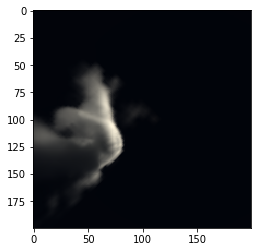

In [4]:
"""
Define a sensor and render a multispectral image of the domain.
"""
projection = shdom.PerspectiveProjection(60.0, 200, 200, 0, 0, 0)
projection.look_at_transform([0.1, 0.1, 0.9], [0, 0, 1])
camera = shdom.Camera(shdom.RadianceSensor(), projection)

image = camera.render(rte_solvers, n_jobs=32)

%matplotlib inline
plt.imshow(image/image.max())

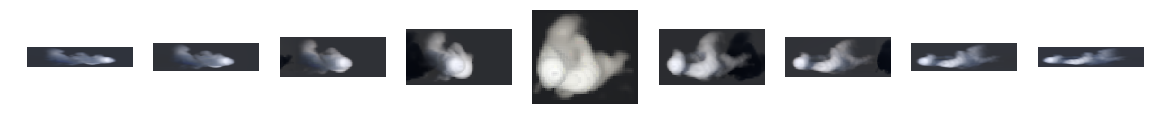

In [5]:
"""
Define a sensor array and render an multi-view, multi-spectral images of the domain. 
Plot the synthetic images.
"""

# A fly over from East to West (negative y-axis direction)
zenith_list = [70.5, 60, 45.6, 26.1, 0, 26.1, 45.6, 60, 70.5]
azimuth_list = [90, 90, 90, 90, 0, -90, -90, -90, -90]

projection = shdom.MultiViewProjection()

for zenith, azimuth in zip(zenith_list, azimuth_list):
    projection.add_projection(
        shdom.OrthographicProjection(
            bounding_box=cloud.bounding_box, 
            x_resolution=0.01, 
            y_resolution=0.01, 
            azimuth=azimuth, 
            zenith=zenith,
            altitude='TOA'
        )
    )
    
camera = shdom.Camera(shdom.RadianceSensor(), projection)
images = camera.render(rte_solvers, n_jobs=60)

%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
for ax, image in zip(axarr, images):
    ax.imshow(image/image.max())
    ax.invert_xaxis() 
    ax.invert_yaxis() 
    ax.axis('off')
